In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas_datareader.data as web
%matplotlib inline

## データの準備
pandas_datareaderを利用してyahooファイナンスから価格を取得する

In [2]:
start = datetime.date.today() - datetime.timedelta(days=20*365)
ohlcv = web.DataReader('MSFT', 'yahoo', start).dropna(axis=0)
ohlcv.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-13,215.800003,206.500000,214.479996,207.070007,38135600.0,207.070007
2020-07-14,208.850006,202.029999,206.130005,208.350006,37591800.0,208.350006
2020-07-15,211.330002,205.029999,209.559998,208.039993,32179400.0,208.039993
2020-07-16,205.699997,202.309998,205.399994,203.919998,29940700.0,203.919998
2020-07-17,205.039993,201.389999,204.470001,202.880005,31588600.0,202.880005


## 騰落率に変換する(定常化)

In [3]:
data = ohlcv.copy()
data = data.pct_change().dropna(axis=0)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-13,0.008034,-0.021698,0.004026,-0.030889,0.456803,-0.030889
2020-07-14,-0.032206,-0.021646,-0.038931,0.006181,-0.014260,0.006181
2020-07-15,0.011875,0.014849,0.016640,-0.001488,-0.143978,-0.001488
2020-07-16,-0.026641,-0.013266,-0.019851,-0.019804,-0.069569,-0.019804
2020-07-17,-0.003209,-0.004547,-0.004528,-0.005100,0.055039,-0.005100


## 計算スピード向上のためnumpy化

In [4]:
data = data.values[:, 0:4]
print(data.shape)

(5027, 4)


In [5]:
print(data[:6, :])

[[-0.01559792 -0.02321429 -0.01734605 -0.02214349]
 [-0.02112676 -0.01645338 -0.02471315 -0.01721014]
 [ 0.00899281  0.00371747 -0.01719457  0.02304147]
 [ 0.02406417  0.03148148  0.04511971  0.0045045 ]
 [-0.00957354 -0.005386   -0.01057269  0.00179372]
 [-0.01493849 -0.01534296 -0.00356189 -0.01611459]]


## future_days日後の終値変動率を予測
yに結果として終値を格納し、Xに予測用のデータを格納する。

In [6]:
future_days = 1
y = data[future_days:, 3]
print(y.shape)
X = data[:len(data) - future_days, :]
print(X.shape)

(5026,)
(5026, 4)


## 入力層の準備
time_steps日分のデータで予測する

In [7]:
time_steps = 100
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(4927, 100, 4) (4927, 1)


## ホールドアウト法で学習用とテスト用のデータを分離する

In [8]:
split = int(0.8 * data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4021, 100, 4) (4021, 1)
(906, 100, 4) (906, 1)


## モデル作成

In [9]:
model = Sequential()

model.add(Conv1D(64, 3, input_shape=(X_train.shape[1], X_train.shape[2]), padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=1))
model.add(Activation('linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 100)           66000     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

## 訓練過程の設定
最適化アルゴリズムにAdamを採用する。

In [10]:
model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])

## 学習を開始する
EarlyStoppingを利用し、過学習の状態となったら自動的に終了する。

In [11]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), callbacks=[es_cb], verbose=2)

Epoch 1/100
16/16 - 1s - loss: 4.4429e-04 - acc: 0.0124 - mae: 0.0151 - val_loss: 3.5215e-04 - val_acc: 0.0099 - val_mae: 0.0126
Epoch 2/100
16/16 - 0s - loss: 3.5184e-04 - acc: 0.0124 - mae: 0.0127 - val_loss: 3.2249e-04 - val_acc: 0.0099 - val_mae: 0.0114
Epoch 3/100
16/16 - 0s - loss: 3.4907e-04 - acc: 0.0124 - mae: 0.0126 - val_loss: 3.2212e-04 - val_acc: 0.0099 - val_mae: 0.0114
Epoch 4/100
16/16 - 0s - loss: 3.4694e-04 - acc: 0.0124 - mae: 0.0126 - val_loss: 3.2662e-04 - val_acc: 0.0099 - val_mae: 0.0116
Epoch 5/100
16/16 - 0s - loss: 3.4621e-04 - acc: 0.0124 - mae: 0.0126 - val_loss: 3.2102e-04 - val_acc: 0.0099 - val_mae: 0.0114
Epoch 6/100
16/16 - 0s - loss: 3.4086e-04 - acc: 0.0124 - mae: 0.0125 - val_loss: 3.2196e-04 - val_acc: 0.0099 - val_mae: 0.0114
Epoch 7/100
16/16 - 0s - loss: 3.4409e-04 - acc: 0.0124 - mae: 0.0126 - val_loss: 3.2174e-04 - val_acc: 0.0099 - val_mae: 0.0114
Epoch 8/100
16/16 - 0s - loss: 3.4085e-04 - acc: 0.0124 - mae: 0.0125 - val_loss: 3.2848e-04 - va

## 学習の進み具合を可視化
学習した結果lossとテストデータのval_lossが収束している事がわかる

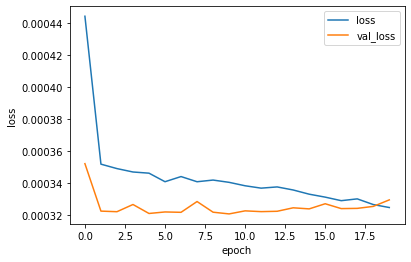

In [12]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

## テストデータで学習結果を評価する

In [13]:
score = model.evaluate(X_test, y_test, batch_size=256)
print('loss:', score[0])
print('acc:', score[1])
print('mae:', score[2])

4/4 [==============================] - 0s 4ms/step - loss: 3.2951e-04 - acc: 0.0099 - mae: 0.0116
loss: 0.00032950841705314815
acc: 0.009933775290846825
mae: 0.01163540966808796


## テストデータの予測結果(y_pred)を作成する

In [14]:
y_pred = model.predict(X_test)

## 騰落率を価格変動に変換する(非定常過程の復元)

In [15]:
pred = []
pred.append(float(1 * (1 + y_pred[0])))
i = 1
while(i < len(y_pred)):
    pred.append(float(pred[i-1] * (1 + y_pred[i])))
    i = i + 1
test = []
test.append(float(1 * (1 + y_test[0])))
i = 1
while(i < len(y_test)):
    test.append(float(test[i-1] * (1 + y_test[i])))
    i = i + 1

## テストデータの結果

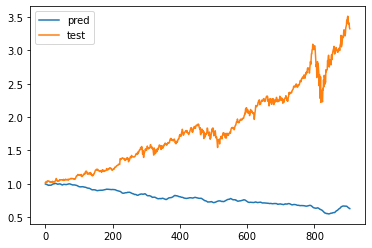

In [16]:
plt.plot(pred, label='pred')
plt.plot(test, label='test')
plt.legend() 
plt.show()

相関係数: 0.03767002475629666


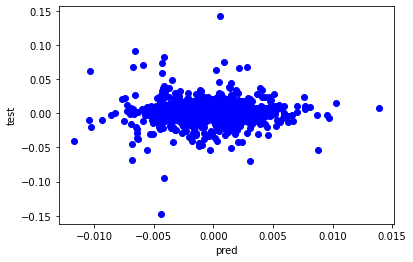

In [17]:
print(f'相関係数: {np.corrcoef(np.ravel(y_pred), np.ravel(y_test))[0,1]}')
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('pred')
plt.ylabel('test')
plt.show()

## テストデータの騰落正答率

In [18]:
data_score = 0
for i in range(y_pred.shape[0] - 1):
    if y_pred[i] > 0 and y_test[i] > 0:
        data_score += 1
    elif y_pred[i] < 0 and y_test[i] < 0:
        data_score += 1
print("score: {}".format(data_score / (y_pred.shape[0] - 1)))

score: 0.5204419889502763


## おわりに
この簡単なモデルでは騰落の正答率が52%と実際のトレードに利用するには難しい事がわかりました。  
がっかりさせてしまったかもしれませんが、機械学習をトレードに利用する事は簡単ではありません。  
ただ、機械学習を利用して収益を上げている方もいらっしゃいますので、このノートブックが貴方の第一歩になれば幸いです。  